In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler

# Funções Úteis

In [2]:
def create_correlation_matrix(
    df: pd.DataFrame, 
    columns: list[str],
    additional_title: str = ""):

    """
     Creates a correlation matrix for the given DataFrame.

    Parameters
    ----------
    df: pd.DataFrame
        The input DataFrame to calculate the correlation matrix for.
    columns: list[str]
        The list of column names to include in the correlation matrix.
    additional_title: str, optional
        An additional title to add to the correlation matrix plot, by default "".
    """

    corr_matrix = df.corr().values
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=True, xticklabels=columns, yticklabels=columns, cmap="YlGnBu", cbar=True)
    plt.title(f"Correlação entre Variáveis {additional_title}")
    plt.show()

In [3]:
def plot_scatterplot(
    df: pd.DataFrame,
    x: str,
    y: str,
    title: str,
    hue: str = None):

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.scatterplot(data=df, x=x, y=y, hue=hue)
    plt.title(title)
    plt.show()

# Coleta de Dados

In [4]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/processed")

In [5]:
complete_data = pd.read_csv(join(DATA_PATH, "complete_df.csv"))

C:\Users\testd\AppData\Local\Temp\ipykernel_16360\1464963469.py:1: DtypeWarning: Columns (23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  complete_data = pd.read_csv(join(DATA_PATH, "complete_df.csv"))


# Preprocessing

In [6]:
complete_data["data"] = pd.to_datetime(complete_data["data"])

In [7]:
feature_cols = [feature for feature in complete_data.columns if feature not in ["id_estacao", "data", "ano", "mes"]]
numerical_cols = [feature for feature in feature_cols if complete_data[feature].dtype in ["float64"]]
categorical_cols = [feature for feature in feature_cols if complete_data[feature].dtype in ["int64", "object"]]

numerical_data = complete_data.groupby(by=["ano", "mes", "data"])[numerical_cols].mean().reset_index()

In [8]:
complete_data = numerical_data.merge(
    complete_data[["data"] + categorical_cols].drop_duplicates(),
    how="left",
    on="data")

In [9]:
complete_data.head()

ano  mes       data  precipitacao_total_media  pressao_atm_hora_media  \
0  2009    1 2009-01-01                  0.149600              970.670937   
1  2009    1 2009-01-02                  0.305735              969.614982   
2  2009    1 2009-01-03                  0.434014              968.136010   
3  2009    1 2009-01-04                  0.245052              969.021543   
4  2009    1 2009-01-05                  0.201583              970.262052   

   pressao_atm_max_media  pressao_atm_min_media  radiacao_global_media  \
0             970.970238             970.382433            2440.168444   
1             969.943108             969.351788            2291.531625   
2             968.457802             967.834482            2149.246228   
3             969.286433             968.697055            2145.260562   
4             970.526035             969.998734            2174.907500   

   temperatura_bulbo_hora_media  temperatura_orvalho_hora_media  ...  \
0                     25.187439                       20.299029  ...   
1                     24.722086                       20.084109  ...   
2                     24.058518                       19.749311  ...   
3                     23.368056                       18.715145  ...   
4                     23.101135                       17.945004  ...   

   vento_rajada_max_media  vento_velocidade_media  categoria_El Ninõ  \
0                4.916689                2.073606                  0   
1                5.280309                2.194251                  0   
2                6.187021                2.625103                  0   
3                5.869366                2.534304                  0   
4                4.674361                1.944461                  0   

   categoria_La Ninã  categoria_Neutro   CO  MP10  MP2.5   O3  SO2  
0                  1                 0  NaN   NaN    NaN  NaN  NaN  
1                  1                 0  NaN   NaN    NaN  NaN  NaN  
2                  1                 0  NaN   NaN    NaN  NaN  NaN  
3                  1                 0  NaN   NaN    NaN  NaN  NaN  
4                  1                 0  NaN   NaN    NaN  NaN  NaN  

[5 rows x 27 columns]

In [10]:
complete_data.shape

(5844, 27)

In [11]:
complete_data.to_csv(f"{MODULE_PATH}/sources/processed/mean_complete_df.csv", index=False)

# Análise Exploratória

## Desvio Padrão

In [10]:
scaler = StandardScaler()
complete_data_scl = scaler.fit_transform(complete_data[numerical_cols])

complete_data_scl = pd.DataFrame(complete_data_scl, columns=numerical_cols)
complete_data_scl["dia_do_ano"] = (pd.to_datetime(complete_data.reset_index()["data"]).dt.day_of_year).astype(str)
complete_data_scl["ano"] = complete_data["ano"].astype(str)
complete_data_scl.set_index(["ano", "dia_do_ano"], inplace=True)

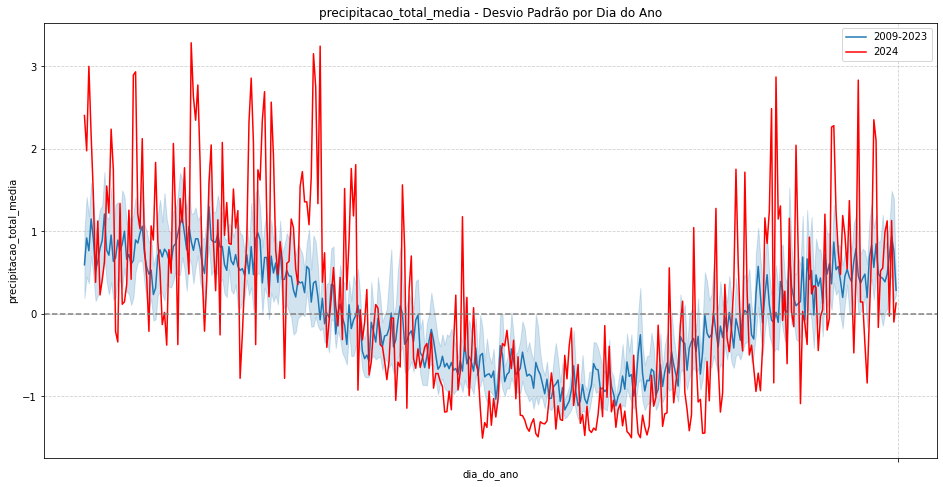

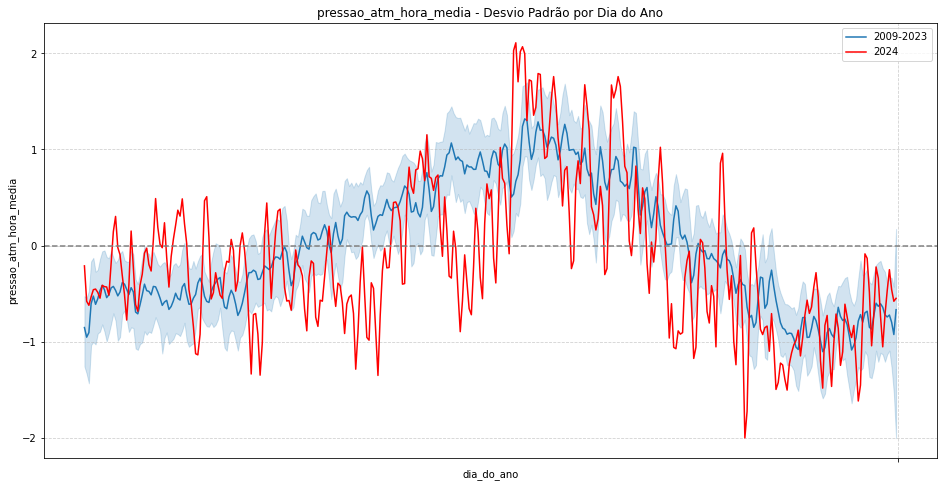

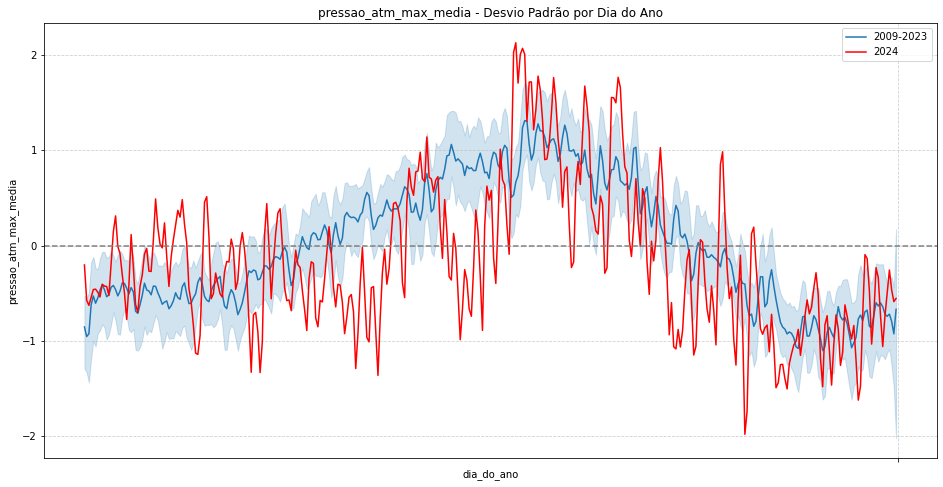

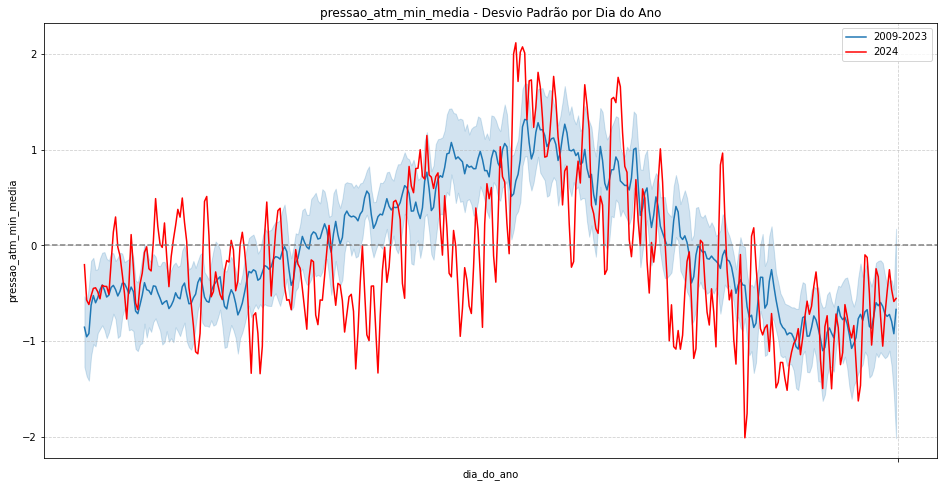

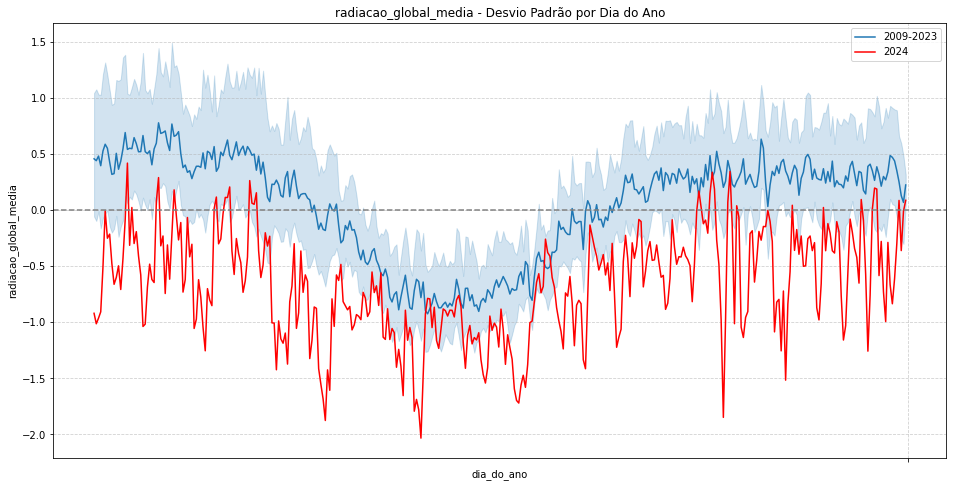

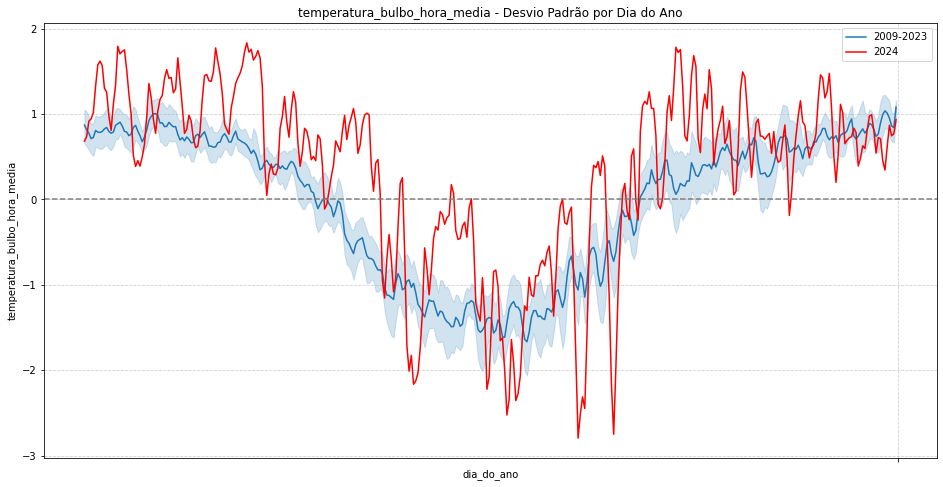

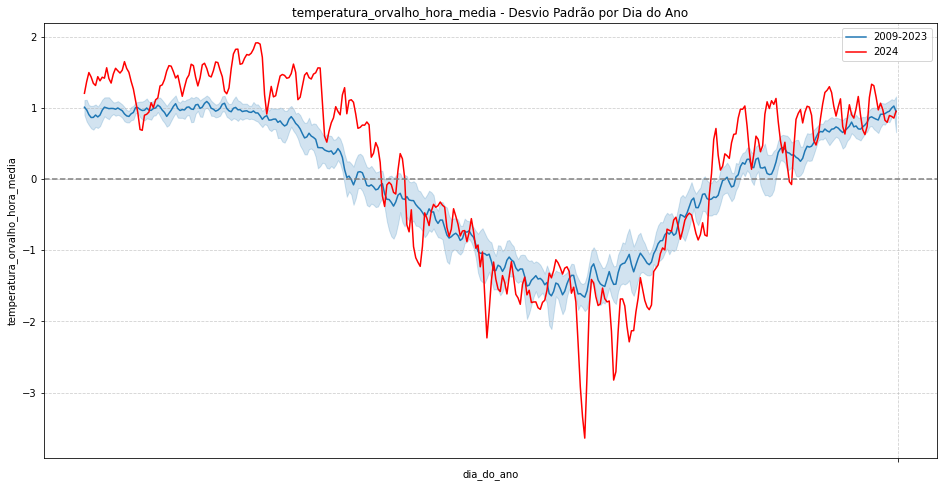

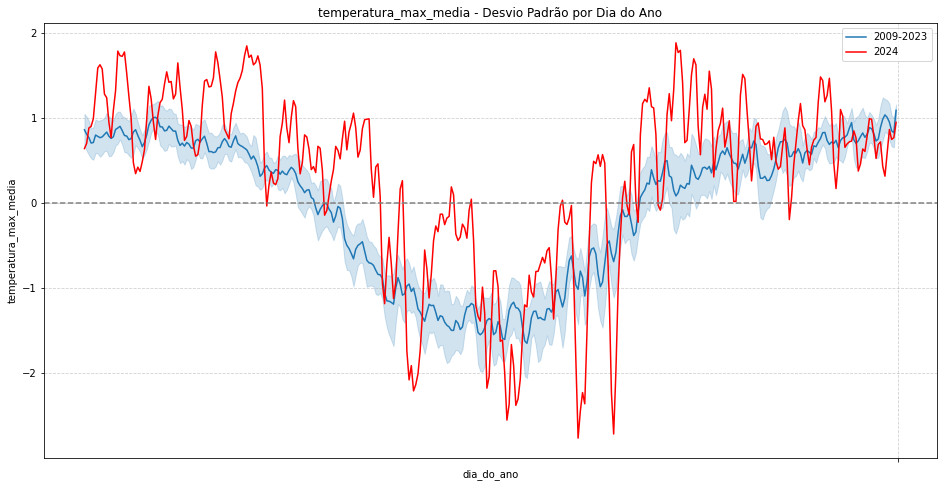

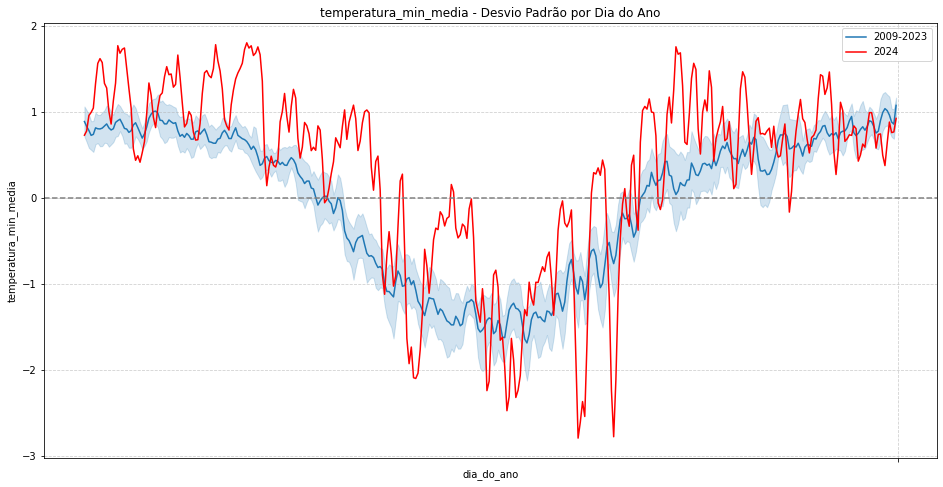

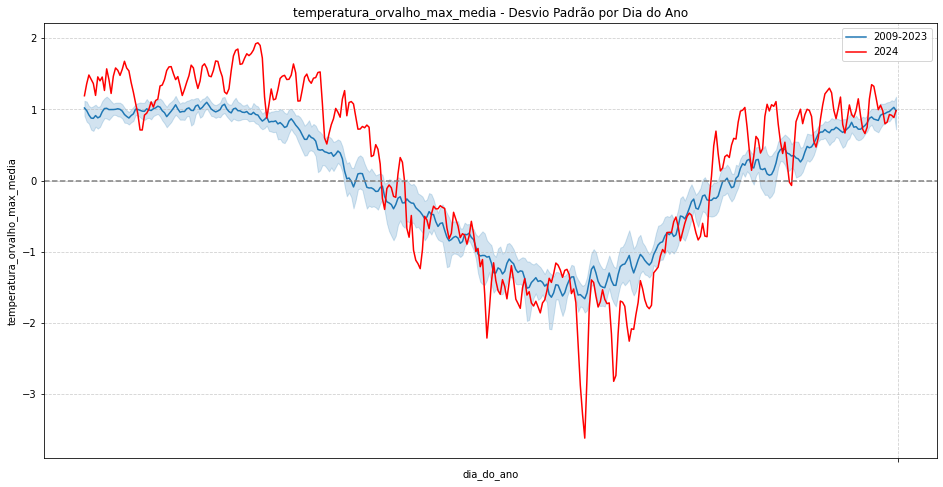

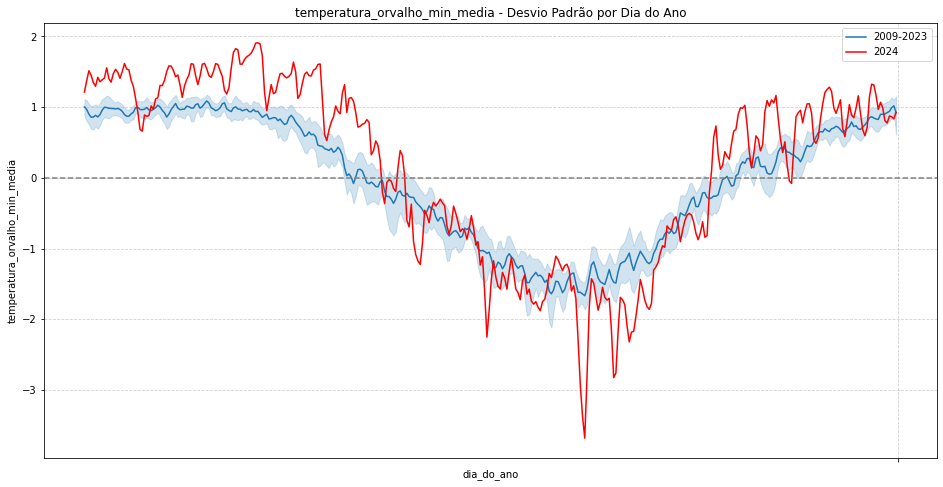

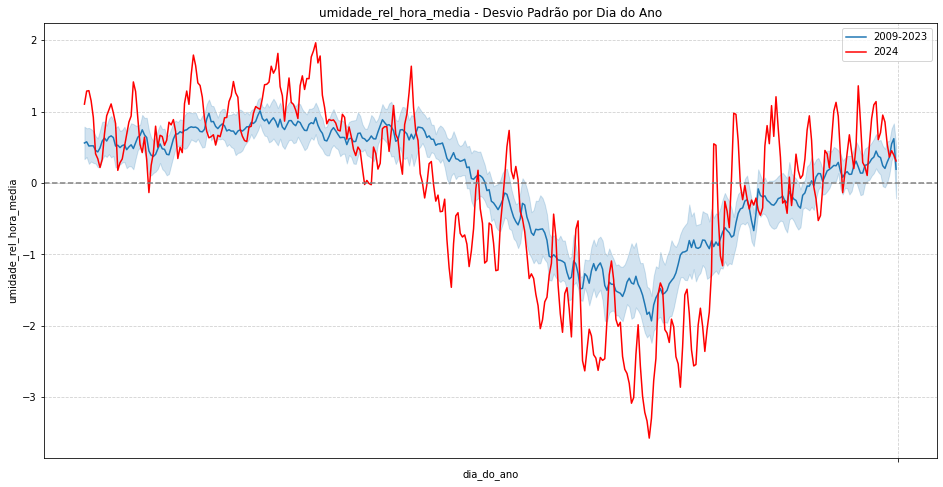

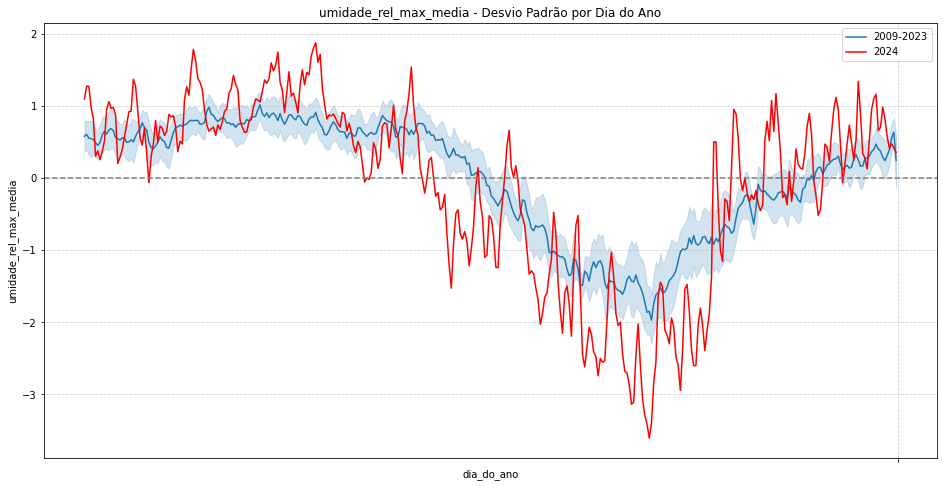

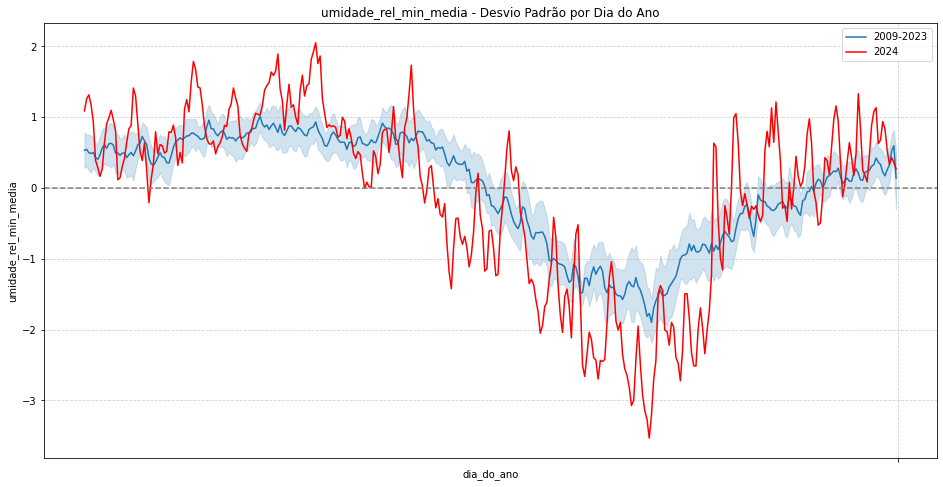

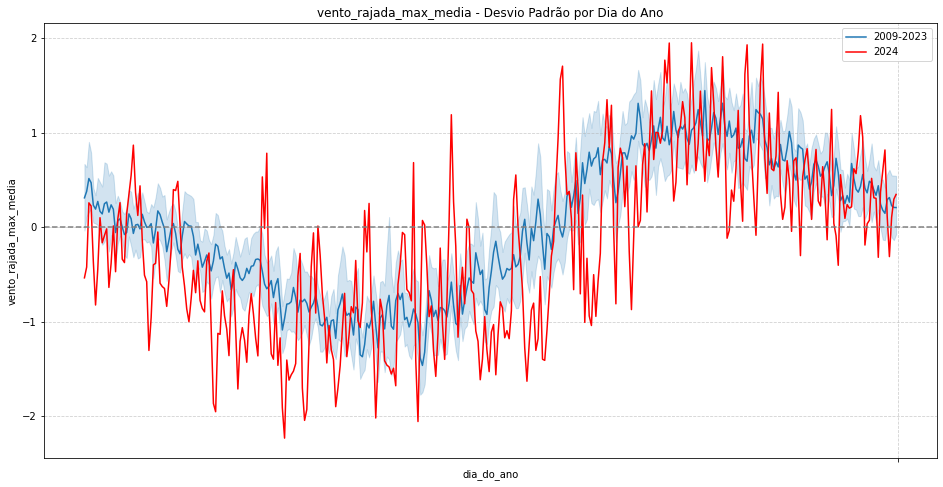

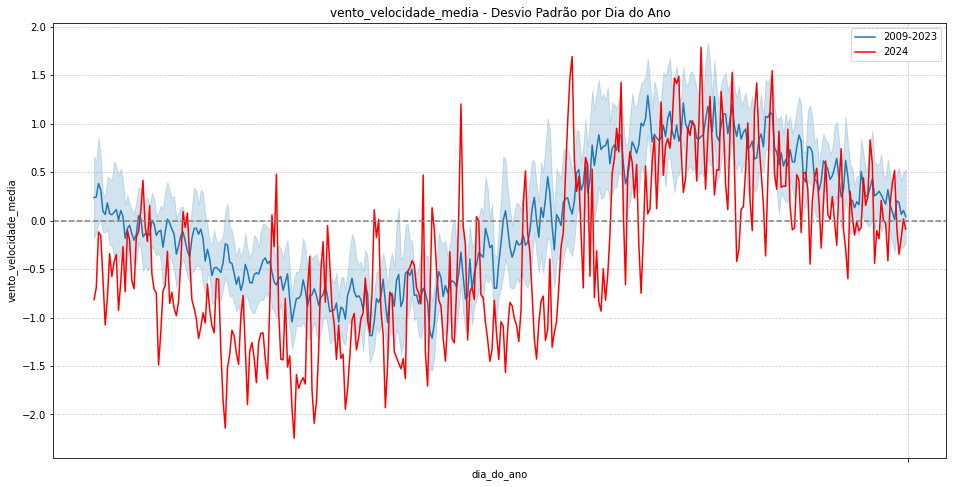

In [11]:
for feature in numerical_cols:
    feature_data = complete_data_scl[feature]
    feature_data = feature_data.reset_index()

    selected_years_data = feature_data[feature_data["ano"] != "2024"]
    last_year_data = feature_data[feature_data["ano"] == "2024"]

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.lineplot(
        y=selected_years_data[feature], 
        x=selected_years_data["dia_do_ano"],
        label="2009-2023")
    sns.lineplot(
        y=last_year_data[feature], 
        x=last_year_data["dia_do_ano"],
        color="red",
        label="2024")
    plt.axhline(0, color="gray", linestyle="--")
    plt.xticks("")
    plt.title(f"{feature} - Desvio Padrão por Dia do Ano")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

## Correlação

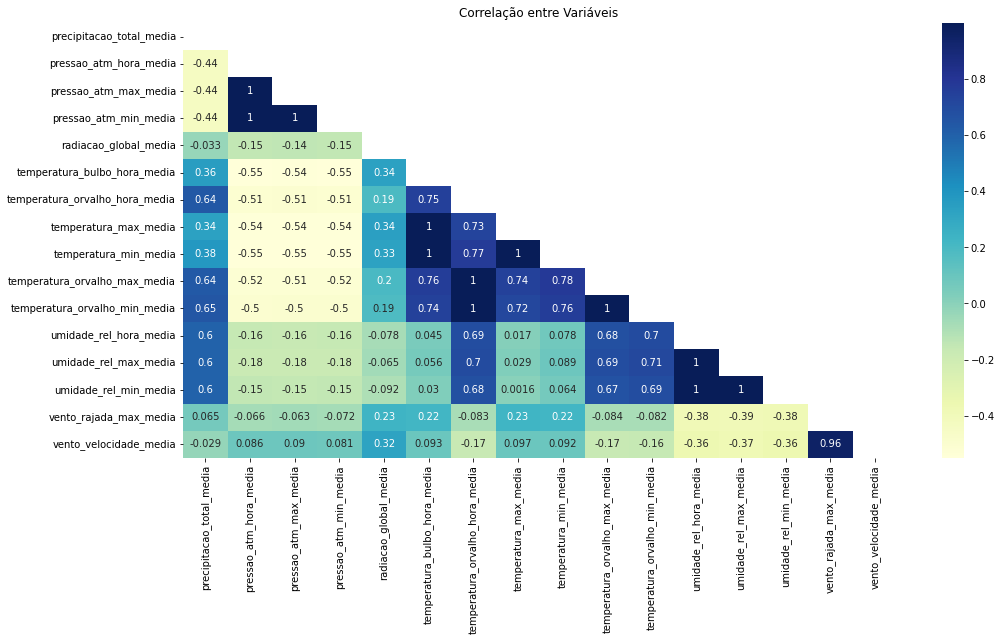

In [12]:
create_correlation_matrix(
    df=complete_data[numerical_cols],
    columns=numerical_cols
)

In [13]:
complete_data["indice_fenomenos"] = (
    complete_data["categoria_El Ninõ"] - complete_data["categoria_La Ninã"]) / (complete_data["categoria_El Ninõ"] + complete_data["categoria_La Ninã"])

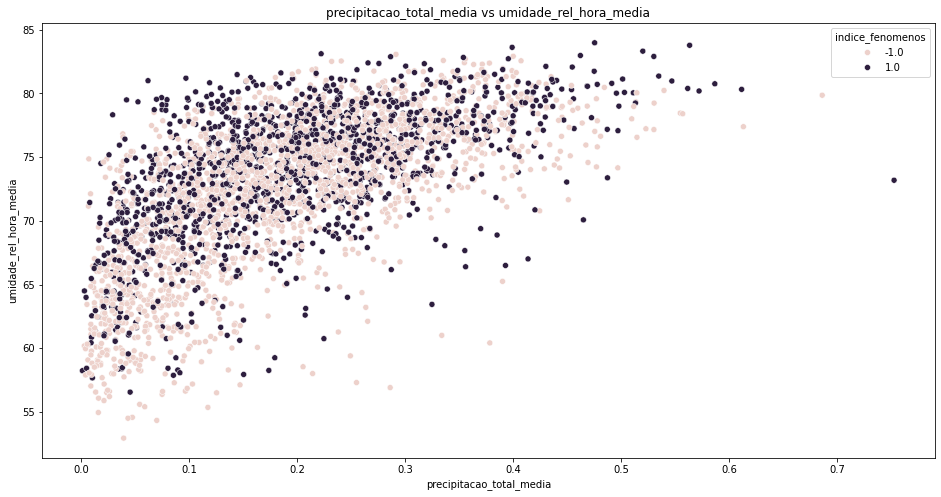

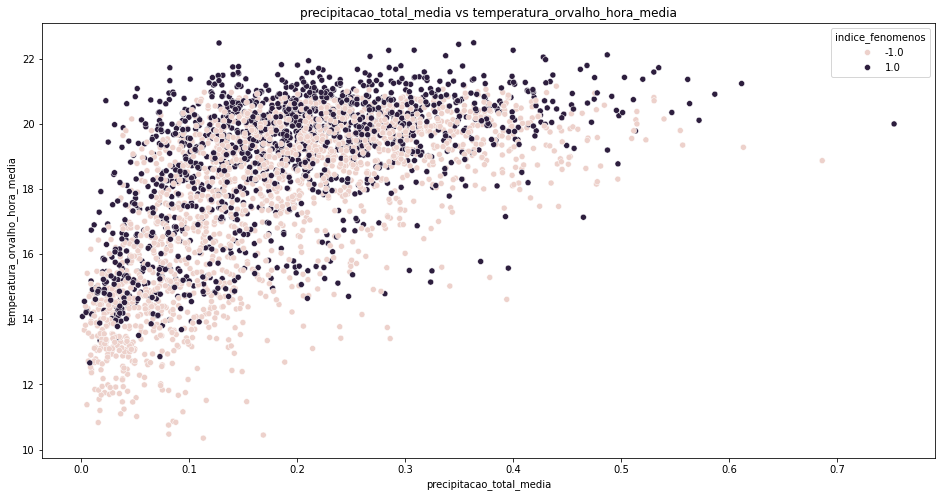

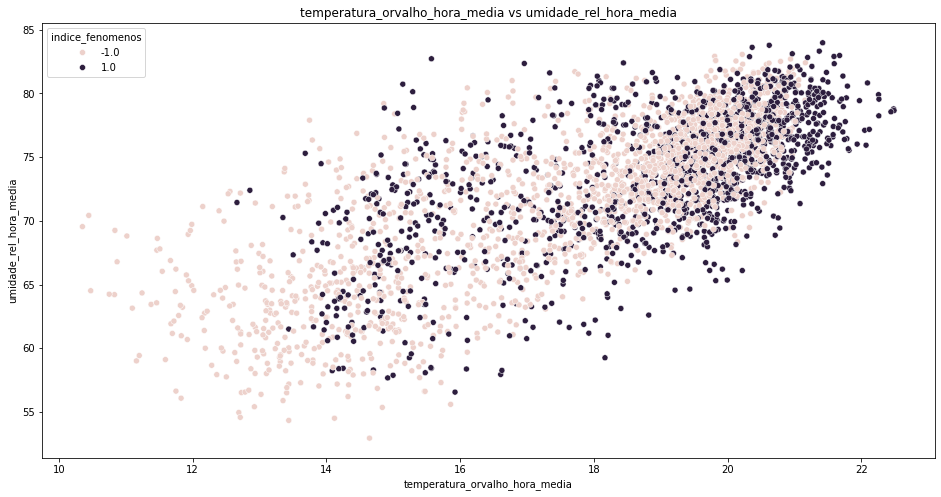

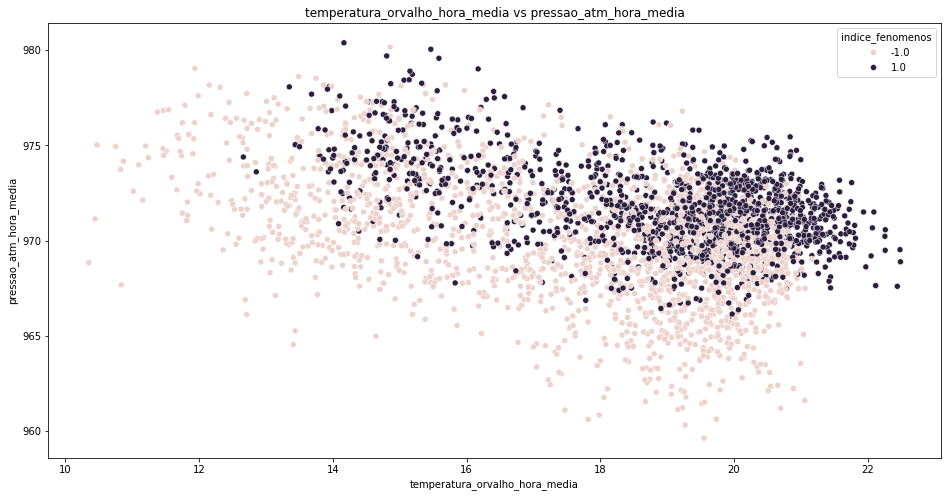

In [14]:
features_to_plot = [
    ("precipitacao_total_media", "umidade_rel_hora_media"),
    ("precipitacao_total_media", "temperatura_orvalho_hora_media"),
    ("temperatura_orvalho_hora_media", "umidade_rel_hora_media"),
    ("temperatura_orvalho_hora_media", "pressao_atm_hora_media")]

for feature_tuple in features_to_plot:

    x = feature_tuple[0]
    y = feature_tuple[1]

    plot_scatterplot(
        df=complete_data,
        x=x,
        y=y,
        title=f"{x} vs {y}",
        hue="indice_fenomenos")

## Agregação Anual

In [15]:
yearly_data = complete_data.groupby("ano")[
    numerical_cols + ["categoria_El Ninõ", "categoria_La Ninã", "categoria_Neutro"]].mean()

In [16]:
yearly_data["indice_fenomenos"] = (
    yearly_data["categoria_El Ninõ"] - yearly_data["categoria_La Ninã"]) / (yearly_data["categoria_El Ninõ"] + yearly_data["categoria_La Ninã"])

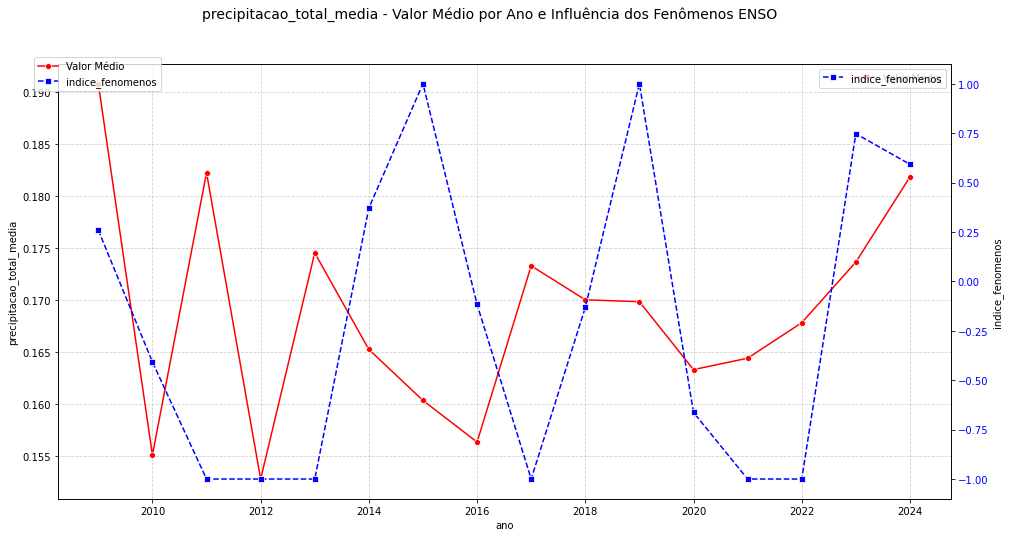

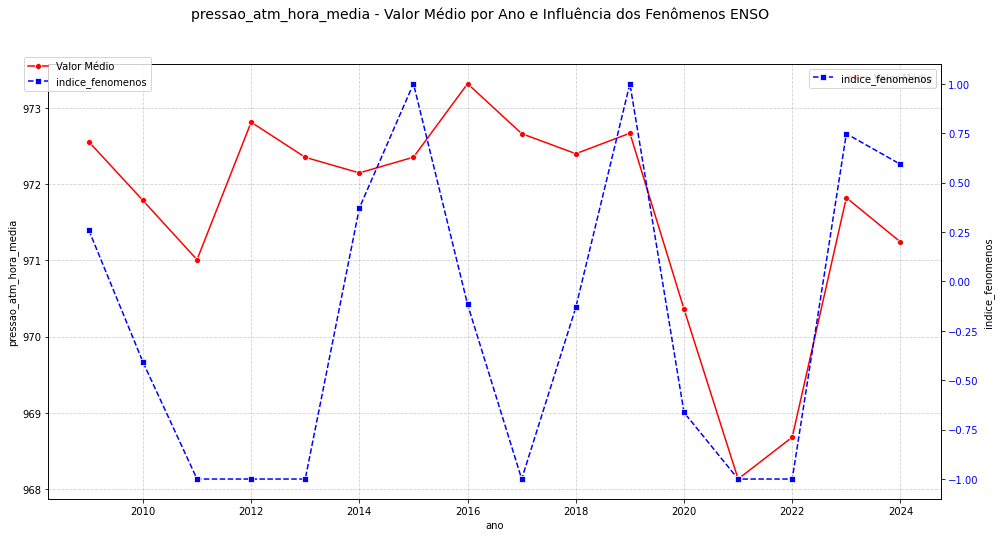

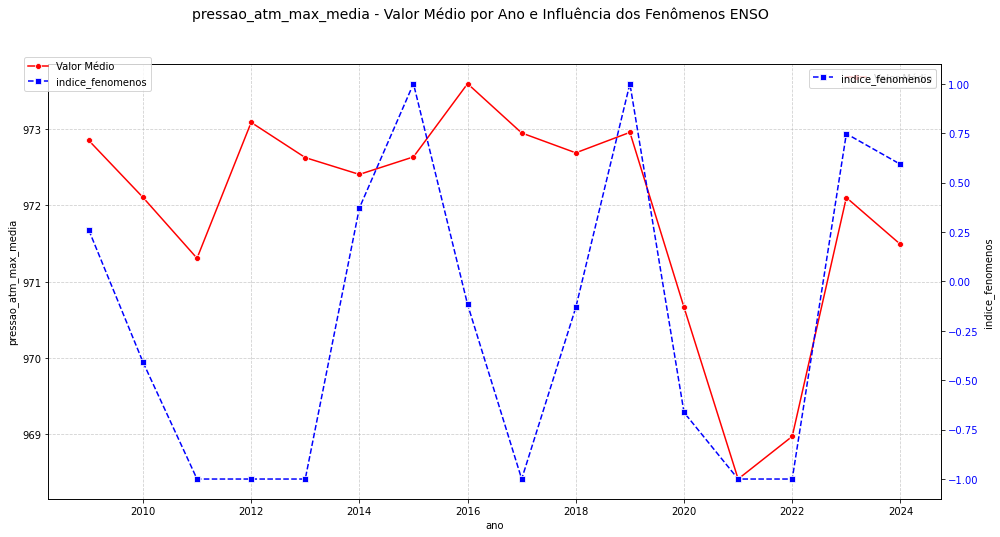

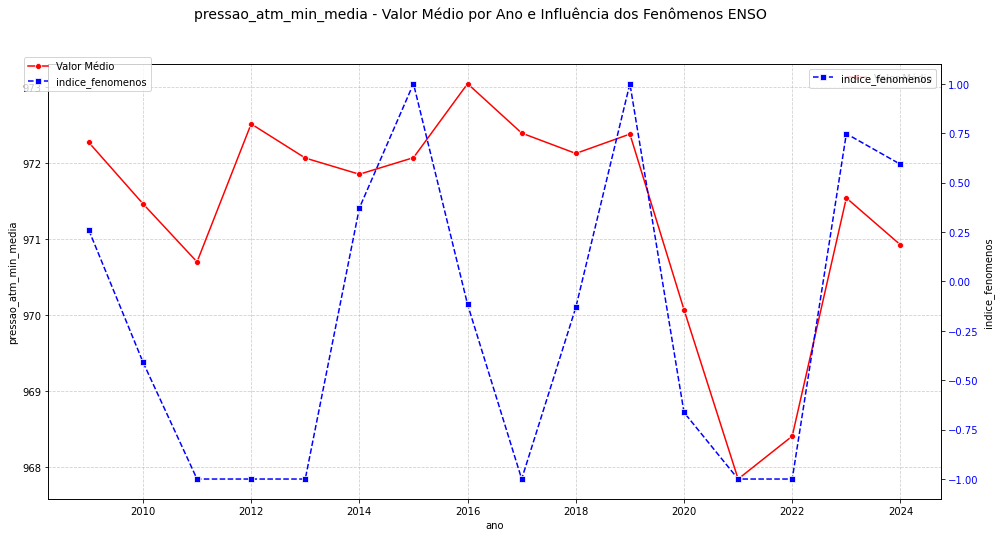

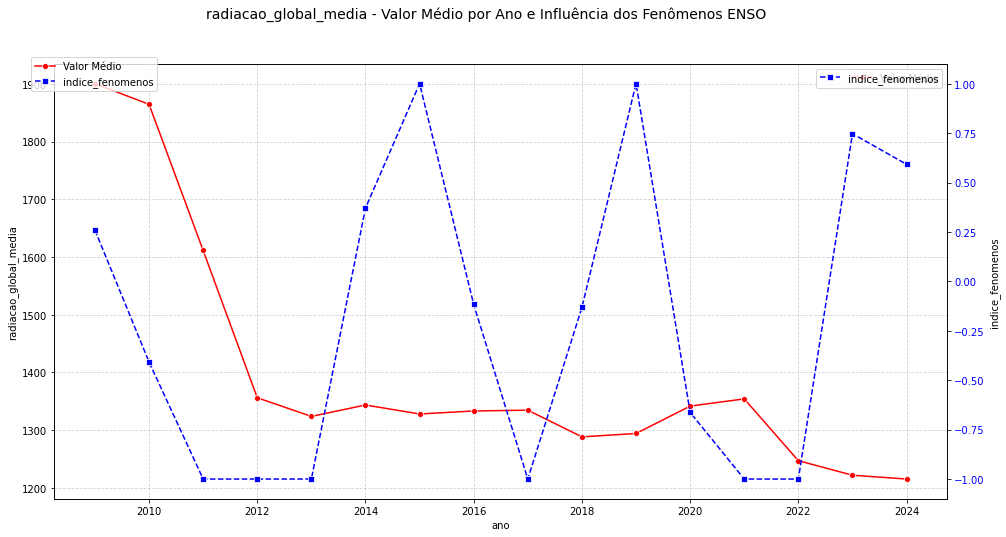

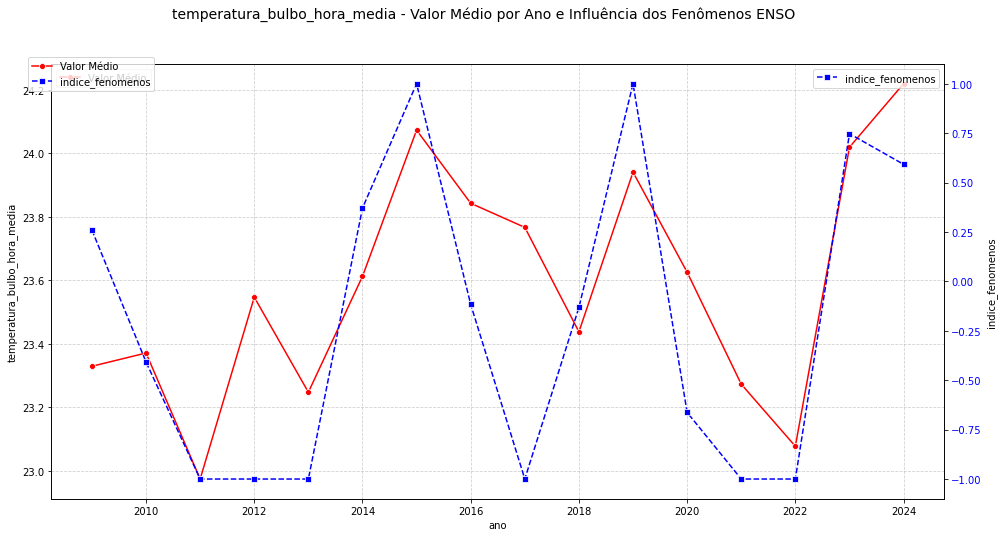

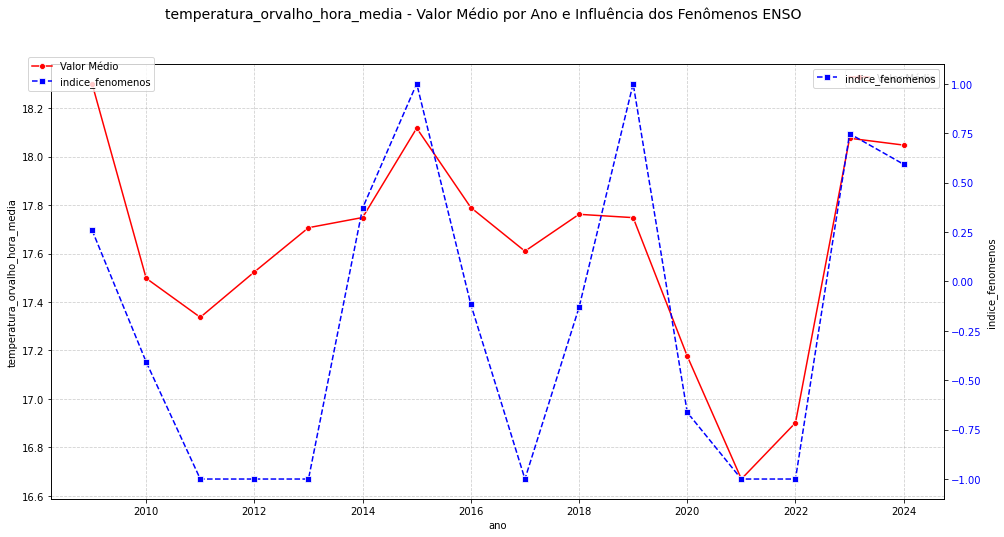

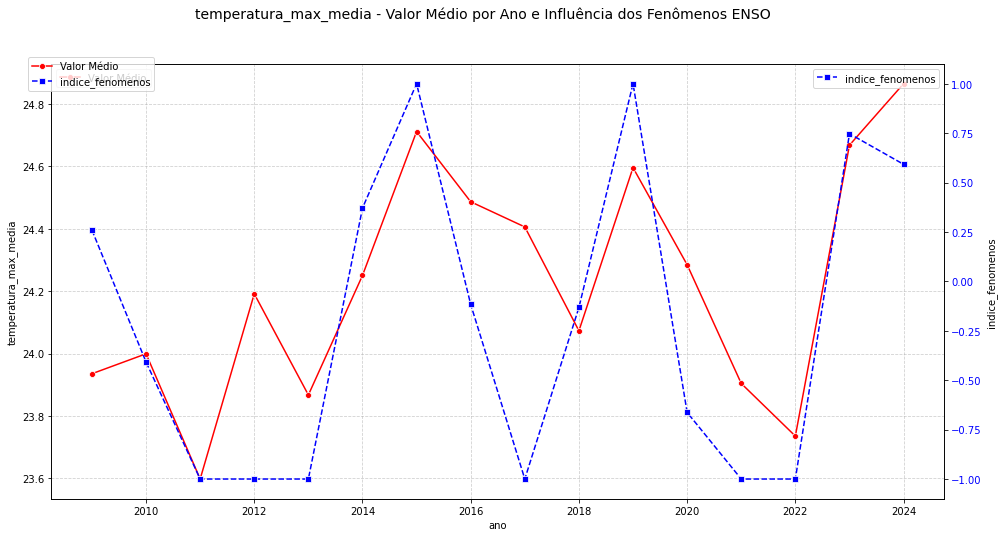

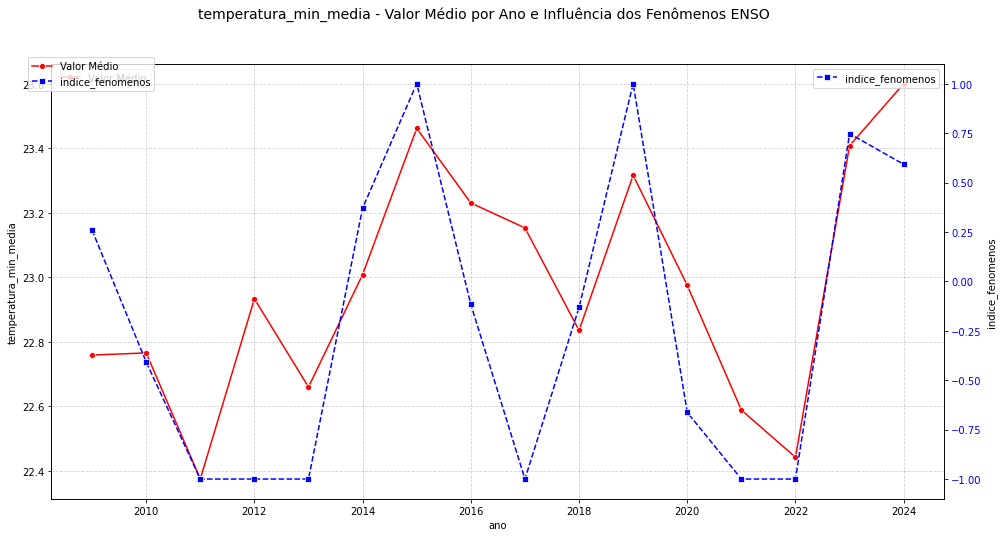

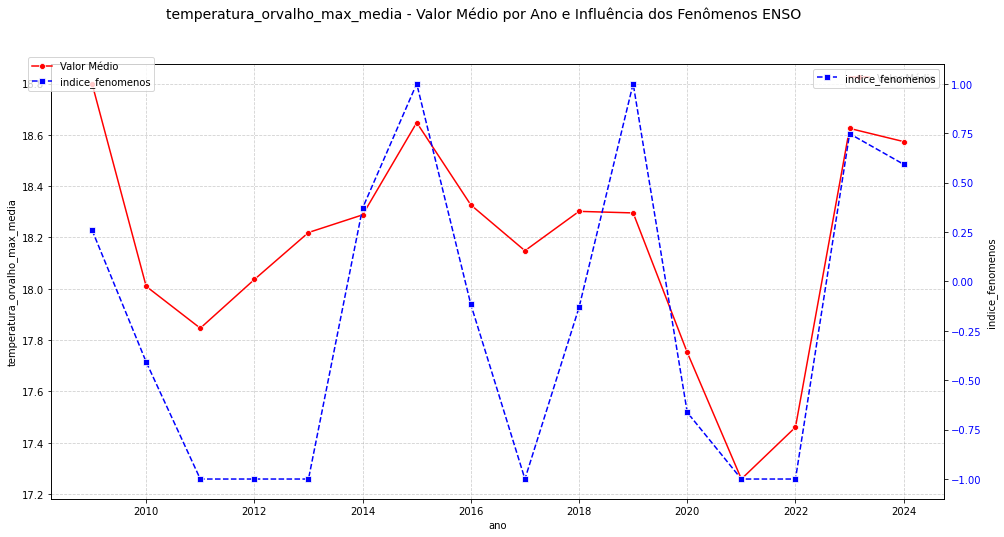

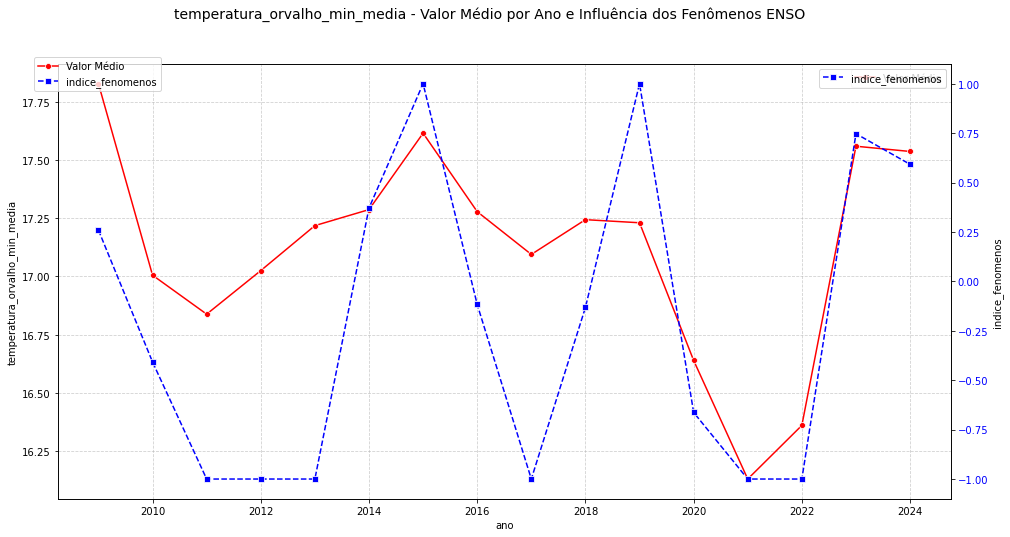

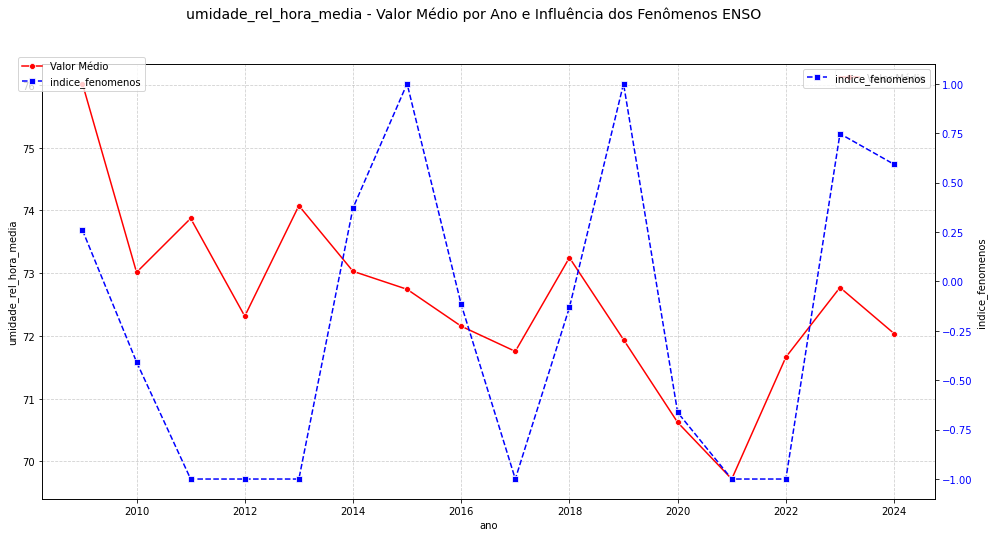

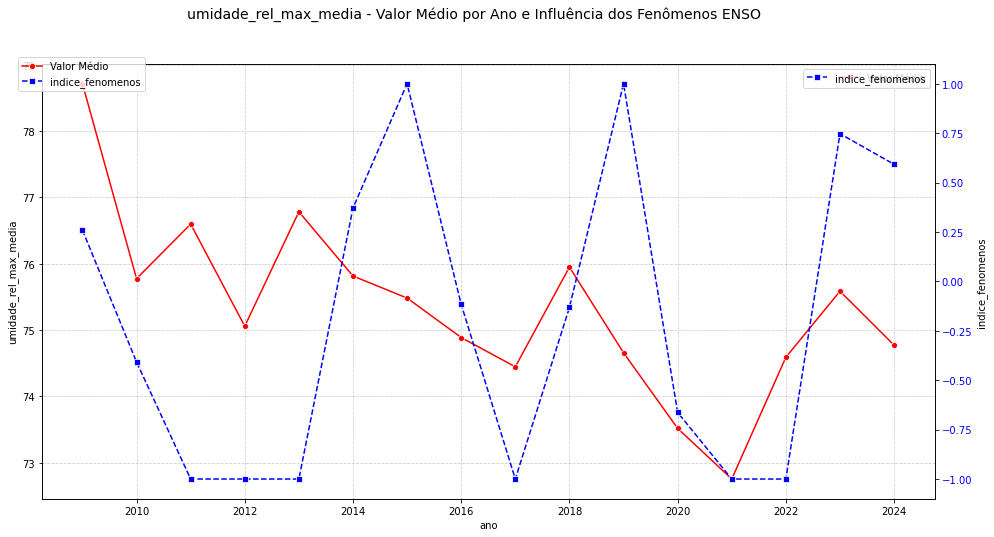

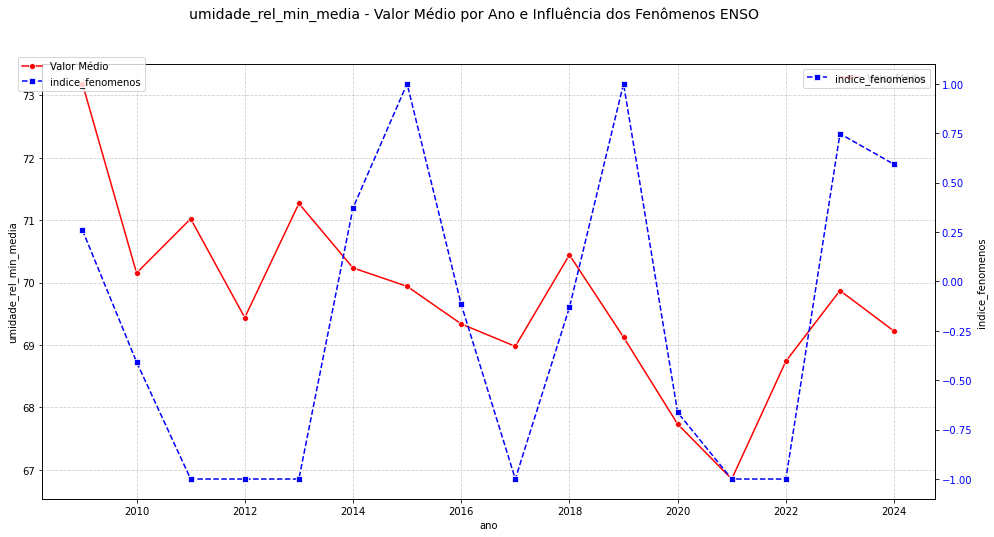

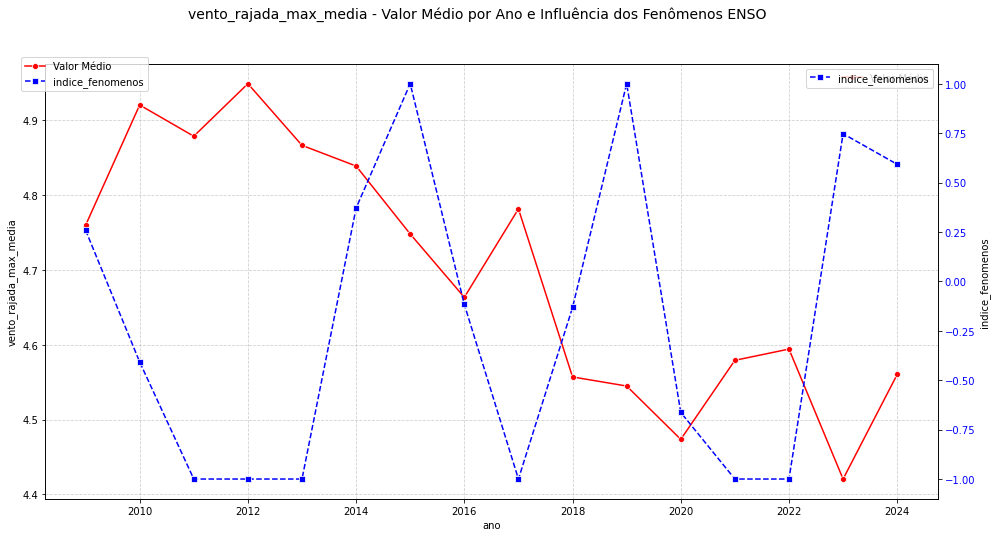

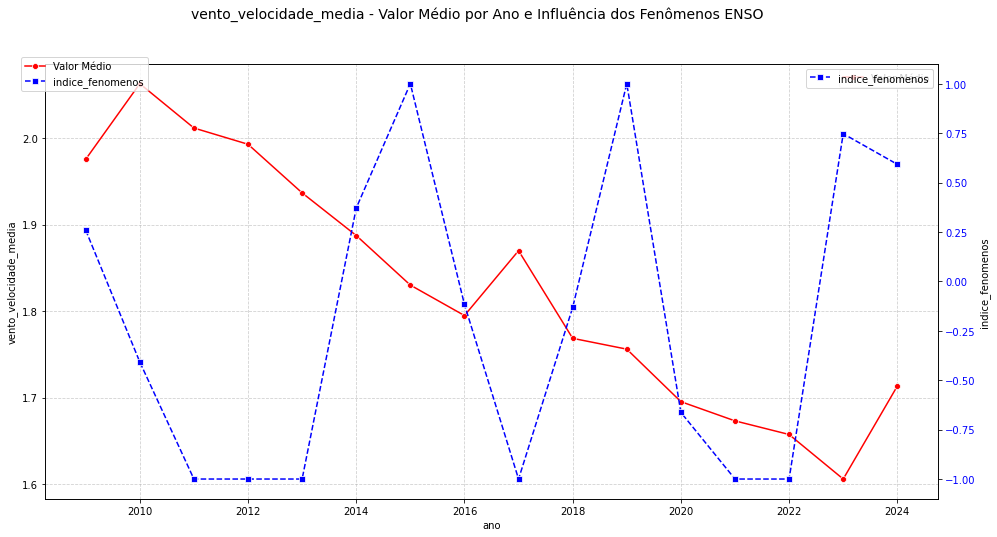

In [17]:
for feature in numerical_cols:
    feature_data = yearly_data[feature].reset_index()
    index_data = yearly_data["indice_fenomenos"].reset_index()
    
    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Primeiro eixo Y - Variável principal
    sns.lineplot(
        x=feature_data["ano"], 
        y=feature_data[feature], 
        ax=ax1,
        color="red",
        marker="o",
        label="Valor Médio")

    # ax1.axhline(yearly_data.mean()[feature], color="orange", linestyle="--", label="Média Histórica (2009-2023)")

    # Anotações nos pontos da variável principal
    # for x, y in zip(feature_data["ano"], feature_data[feature]):
    #     ax1.annotate(f"{y:.3f}", (x, y), textcoords="offset points", xytext=(0, 8), ha="center", fontsize=10, color="black")

    # ax1.annotate(f"{yearly_data.mean()[feature]:.2f}", 
    #              xy=(feature_data["ano"].max(), yearly_data.mean()[feature]),  
    #              xytext=(5, 0), textcoords="offset points",
    #              fontsize=11, color="orange", fontweight="bold")

    # ax1.set_xlabel("Ano")
    # ax1.set_ylabel(f"{feature} (Valor Médio)")
    # ax1.tick_params(axis="y", labelcolor="red")
    ax1.grid(True, linestyle="--", alpha=0.6)

    # Segundo eixo Y - Índice Normalizado
    ax2 = ax1.twinx()
    sns.lineplot(
        x=index_data["ano"], 
        y=index_data["indice_fenomenos"], 
        ax=ax2,
        color="blue",
        marker="s",
        linestyle="dashed",
        label="indice_fenomenos")

    ax2.set_ylabel("indice_fenomenos")
    ax2.tick_params(axis="y", labelcolor="blue")

    fig.suptitle(f"{feature} - Valor Médio por Ano e Influência dos Fenômenos ENSO", fontsize=14)
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

    plt.show()


## Qualidade do Ar

In [18]:
data_quality_period = complete_data.loc[(complete_data["ano"] >= 2015) & (complete_data["ano"] <= 2022)]

In [19]:
data_quality_cols = ["CO", "MP10", "MP2.5", "O3", "SO2"]

In [20]:
data_quality_period

ano  mes       data  precipitacao_total_media  pressao_atm_hora_media  \
2191  2015    1 2015-01-01                  0.243209              968.619922   
2192  2015    1 2015-01-02                  0.162862              969.267051   
2193  2015    1 2015-01-03                  0.164388              970.426775   
2194  2015    1 2015-01-04                  0.287958              971.328726   
2195  2015    1 2015-01-05                  0.190865              971.508776   
...    ...  ...        ...                       ...                     ...   
5108  2022   12 2022-12-27                  0.322634              968.895434   
5109  2022   12 2022-12-28                  0.459769              968.677375   
5110  2022   12 2022-12-29                  0.371021              969.823778   
5111  2022   12 2022-12-30                  0.325306              969.991985   
5112  2022   12 2022-12-31                  0.270462              970.572995   

      pressao_atm_max_media  pressao_atm_min_media  radiacao_global_media  \
2191             968.931343             968.317545            1554.766897   
2192             969.527877             968.933343            1540.481431   
2193             970.707514             970.121138            1538.096493   
2194             971.606492             971.017398            1481.138946   
2195             971.772218             971.249138            1527.933776   
...                     ...                    ...                    ...   
5108             969.149310             968.620529            1117.090987   
5109             968.986287             968.387372            1164.142457   
5110             970.079790             969.536819            1275.218040   
5111             970.269093             969.743432            1281.025363   
5112             970.848132             970.304359            1355.258226   

      temperatura_bulbo_hora_media  temperatura_orvalho_hora_media  ...  \
2191                     26.125836                       20.048796  ...   
2192                     25.827945                       19.760268  ...   
2193                     25.261554                       19.691951  ...   
2194                     24.908922                       19.587394  ...   
2195                     24.953988                       19.636223  ...   
...                            ...                             ...  ...   
5108                     24.170105                       19.762400  ...   
5109                     24.193428                       19.835111  ...   
5110                     24.222825                       18.971824  ...   
5111                     24.403687                       18.833237  ...   
5112                     25.080843                       19.534695  ...   

      vento_velocidade_media  categoria_El Ninõ  categoria_La Ninã  \
2191                2.111379                  1                  0   
2192                1.882778                  1                  0   
2193                1.585587                  1                  0   
2194                1.751781                  1                  0   
2195                1.755241                  1                  0   
...                      ...                ...                ...   
5108                1.547712                  0                  1   
5109                1.768197                  0                  1   
5110                1.588778                  0                  1   
5111                1.498049                  0                  1   
5112                1.565840                  0                  1   

      categoria_Neutro   CO  MP10  MP2.5   O3  SO2  indice_fenomenos  
2191                 0  Boa   Boa    Boa  Boa  Boa               1.0  
2192                 0  Boa   Boa    Boa  Boa  Boa               1.0  
2193                 0  Boa   Boa    Boa  Boa  Boa               1.0  
2194                 0  Boa   Boa    Boa  Boa  Boa               1.0  
2195                 0  

In [21]:
data_quality_period_melted = data_quality_period.melt(id_vars=["data"], value_vars=data_quality_cols)

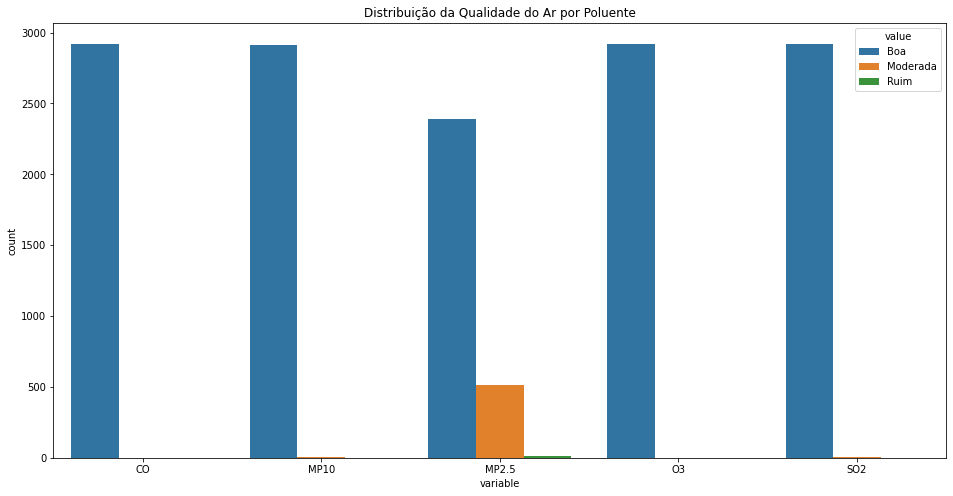

In [22]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(
    data=data_quality_period_melted,
    x="variable",
    hue="value",
    ax=ax
)
plt.title("Distribuição da Qualidade do Ar por Poluente")
plt.show()

In [23]:
data_quality_period_melted.loc[data_quality_period_melted["value"] != "Boa"]

data variable     value
3188  2015-09-24     MP10  Moderada
3189  2015-09-25     MP10  Moderada
3210  2015-10-16     MP10  Moderada
4637  2019-09-12     MP10  Moderada
4643  2019-09-18     MP10  Moderada
...          ...      ...       ...
12611 2017-07-12      SO2  Moderada
12688 2017-09-27      SO2  Moderada
14113 2021-08-22      SO2  Moderada
14448 2022-07-23      SO2  Moderada
14450 2022-07-25      SO2  Moderada

[543 rows x 3 columns]